## Prepare Dataset

In [9]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

features = ['unix_timestamp', 'open', 'high', 'low', 'close', 'volume'] # full

raw_csv_data = pd.read_csv("DataSets/2019/intraday_2019_03_5min_IBM.csv")
raw_csv_data = raw_csv_data[::-1]

print(raw_csv_data)

# Create DataFrame
df = pd.DataFrame(raw_csv_data, columns=
    features
)
df = df.astype(float)

# Convert the datetime to Unix timestamp (in seconds)
df['unix_timestamp'] = pd.to_datetime(raw_csv_data['timestamp']).astype('int64') // 10**9

# Handle missing values
#df = df.ffill()  # Forward fill missing values

print(df.head(5))

# Create sequences (using 60 time steps to predict next value)
# Sliding-Window over the dataset, to give ML more context
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length, [4,5]])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # 5 hours of history (60 * 5min)

feature_columns = {features[i] : i for i in range(len(features))}

# Split data PROPERLY
split_idx = int(0.8 * len(df))
train_raw = df.iloc[:split_idx]
test_raw = df.iloc[split_idx:]

# Scale using TRAINING DATA ONLY
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(train_raw)
scaled_test = scaler.transform(test_raw)

# Create sequences
X_train, y_train = create_sequences(scaled_train, SEQ_LENGTH)
X_test, y_test = create_sequences(scaled_test, SEQ_LENGTH)
# 
time_step = scaled_train[1][0] - scaled_train[0][0]
print("time step: ", time_step)

print("ytest:\n", y_test[0:5])

# X, y = create_sequences(scaled_all, SEQ_LENGTH)
# Split into train/test
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

class StockPredictionDataSet(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        self.X_tensor = torch.Tensor(X_data).to(device)
        self.y_tensor = torch.Tensor(y_data).to(device)
        
    def __getitem__(self, idx):
        return self.X_tensor[idx], self.y_tensor[idx]
    
    def __len__(self):
        return len(self.X_tensor)

                timestamp      open      high       low     close  volume
1880  2019-03-01 09:00:00  101.0623  101.0623  101.0333  101.0333     370
1879  2019-03-01 09:25:00  100.9752  100.9752  100.9752  100.9752     252
1878  2019-03-01 09:30:00  101.1277  101.3890  101.0841  101.1495  126567
1877  2019-03-01 09:35:00  101.1495  101.3237  101.1422  101.3128   27682
1876  2019-03-01 09:40:00  101.3309  101.3672  101.2438  101.3455   53126
...                   ...       ...       ...       ...       ...     ...
4     2019-03-29 16:45:00  102.4053  102.4053  102.4053  102.4053     523
3     2019-03-29 16:50:00  102.3908  102.3980  102.3908  102.3980    2165
2     2019-03-29 16:55:00  102.3980  102.3980  102.3980  102.3980     104
1     2019-03-29 17:30:00  102.3980  102.3980  102.3980  102.3980     104
0     2019-03-29 17:35:00  102.3908  102.3908  102.3908  102.3908     104

[1881 rows x 6 columns]
      unix_timestamp      open      high       low     close    volume
1880      155143

## Prepare LSTM AI

In [2]:
import torch
import torch.nn as nn

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

print("Is cuda available:", torch.cuda.is_available())  # Should return True
print(torch.version.cuda)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# For mixed precision training (optional but recommended)
grad_scaler = torch.amp.GradScaler(device=device, init_scale=2.**16)

class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 2) # output size
        # self.fc_mu = nn.Linear(hidden_size, 2)  # Mean predictions
        # self.fc_var = nn.Linear(hidden_size, 2) # Variance
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last time step's output
        return out

# Hyperparameters
model = StockPredictor(
    input_size=len(features),   # (timestamp, open, high, low, close, volume)
    hidden_size=256, # Increases training time
    num_layers=4 # Increases training time
).to(device)

# Optional: Enable cudnn optimizations
# torch.backends.cudnn.benchmark = True

CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4080
Is cuda available: True
12.8
Using device: cuda


### Prepare Data

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Initialize train dataset
train_dataset = StockPredictionDataSet(X_train, y_train)

# Use pinned memory and multiple workers
train_loader = DataLoader(
    train_dataset,
    batch_size=4096,  # Adjust based on GPU memory
    shuffle=False,
    num_workers=0,
)

class VolatilityWeightedLoss(nn.Module): # Custom loss function (Unused)
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, targets):
        # Calculate volatility weights
        price_changes = targets[:,0] - inputs[:,0]
        weights = torch.abs(price_changes) * 5  # Amplify large moves
        
        # Weighted MSE
        return torch.mean(weights * (inputs - targets)**2)

## Training

In [11]:
criterion = nn.MSELoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100): # More epoch -> more trained (takes longer)
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Automatic mixed precision
        with torch.amp.autocast(device.type):
            outputs = model(batch_X)
            # Add Gaussian noise (1% of price range)
            noise = torch.randn_like(outputs) * 0.002
            outputs += noise
            loss = criterion(outputs, batch_y)
        
        # Scaled backpropagation
        optimizer.zero_grad(set_to_none=True)  # More memory efficient
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 10, Loss: 0.0094
Epoch 20, Loss: 0.0090
Epoch 30, Loss: 0.0060
Epoch 40, Loss: 0.0051
Epoch 50, Loss: 0.0049
Epoch 60, Loss: 0.0047
Epoch 70, Loss: 0.0045
Epoch 80, Loss: 0.0044
Epoch 90, Loss: 0.0043
Epoch 100, Loss: 0.0043


## Evaluate

In [12]:
def autoregressive_predict(model, scaler, initial_sequence, true_test_data, feature_columns):
    """
    Simulates real-world prediction without future data access
    - initial_sequence: Last SEQ_LENGTH training samples (scaled)
    - true_test_data: Actual test data for comparison (scaled)
    - feature_columns: Indices of [open, high, low, close, volume]
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(len(true_test_data)):
        # Predict next close price
        with torch.no_grad():
            inputs = torch.Tensor(current_sequence).unsqueeze(0).to(device)
            pred_scaled = model(inputs).squeeze().cpu().numpy()
            
        # Store prediction
        predictions.append(pred_scaled)
        
        # Create new feature vector (critical!)
        new_features = np.zeros(len(current_sequence[0]))
        
        pred_close_price = pred_scaled[0]
        pred_vol = pred_scaled[1]
        
        # Calculate timestamp (previous timestamp + 5min)
        last_timestamp = current_sequence[-1, feature_columns['unix_timestamp']]
        new_timestamp = last_timestamp + time_step  # 5 minutes in seconds
        new_features[feature_columns['unix_timestamp']] = new_timestamp
        
       # Add realistic noise (0.5% of current price)
        noise_scale = abs(pred_close_price * 0.05)
        pred_close_price += np.random.normal(0, noise_scale)
        
        # Estimated OHLC (using predicted close as all values)
        new_features[feature_columns['open']] = pred_close_price
        new_features[feature_columns['high']] = pred_close_price
        new_features[feature_columns['low']] = pred_close_price
        new_features[feature_columns['close']] = pred_close_price
        
        # Volume handling (set to 0 or average)
        new_features[feature_columns['volume']] = pred_vol  # Or use historical average
        
        # Update sequence (remove oldest, add new prediction)
        current_sequence = np.vstack([current_sequence[1:], new_features])
    
    return predictions

In [13]:
import matplotlib.pyplot as plt
def visualize_predictions(model, scaler, train_data, test_data, seq_length, feature_columns):
    # Get initial sequence (last training samples)
    initial_sequence = train_data[-seq_length:]
    
    #print(initial_sequence[::20])
    
    # Make autoregressive predictions
    test_predictions = np.array(autoregressive_predict(
        model, scaler, initial_sequence, 
        test_data, feature_columns
    ))
    
    #print(test_predictions[::20])
    
    # Inverse scaling for meaningful values
    def inverse_scale(preds, scaler, data_shape):
        dummy = np.zeros((len(preds), data_shape))
        #dummy[:, 0] = preds[:, 0]  # 'timestamp' is at index 0
        dummy[:, feature_columns['close']] = preds[:, 0]  # 'close' is at index 4
        #dummy[:, 5] = preds[:, 1]  # 'vol' is at index 5
        return scaler.inverse_transform(dummy)[:, feature_columns['close']]
    
    # # Inverse scaling
    # def inverse_scale_pred(pred, scaler, feature_columns):
    #     dummy = np.zeros((3, df.shape[1]))
    #     dummy[:, feature_columns['close']] = pred
    #     return scaler.inverse_transform(dummy)[0, feature_columns['close']]
    
    # Convert predictions to actual prices
    pred_prices = inverse_scale(test_predictions, scaler, df.shape[1]) #[inverse_scale_pred(p, scaler, feature_columns) for p in test_predictions]
    true_prices = scaler.inverse_transform(test_data)[:, feature_columns['close']]
    
    # Create timeline
    train_timestamps = df.index[seq_length:len(train_data)]
    test_timestamps = df.index[len(train_data):len(train_data)+len(test_data)]
    
    plt.figure(figsize=(16, 8))
    
    # Plot historical data
    plt.plot(df.index[:len(train_data)], 
             scaler.inverse_transform(train_data)[:, feature_columns['close']], 
             label='Historical Prices', alpha=0.4)
    
    #X_train_timestamps = df.index[seq_length:len(X_train)]
    # Plot training predictions
    train_sequences = torch.Tensor(X_train).to(device)
    with torch.no_grad():
        train_preds = model(train_sequences).squeeze().cpu().numpy()
    #print(train_preds[::20])
    # full_inputs = torch.Tensor(train_data).to(device)
    # train_preds = model(full_inputs).detach().cpu().numpy()
    train_pred_prices = inverse_scale(train_preds, scaler, df.shape[1]) #[inverse_scale_pred(p, scaler, feature_columns) for p in train_preds[seq_length:]]
    #print(train_pred_prices)
    plt.plot(train_timestamps, train_pred_prices, 
             label='Training Fit', linestyle='--')
    
    # Plot test predictions
    plt.plot(test_timestamps, pred_prices, 
             label='Autoregressive Predictions', linewidth=2)
    
    # Plot actual test prices
    plt.plot(test_timestamps, true_prices, 
             label='True Future Prices', alpha=0.7)
    
    plt.axvline(x=test_timestamps[0], color='black', 
                linestyle='--', label='Prediction Start')
    plt.gca().invert_xaxis()
    plt.title('Realistic Stock Price Prediction Performance')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return pred_prices, true_prices

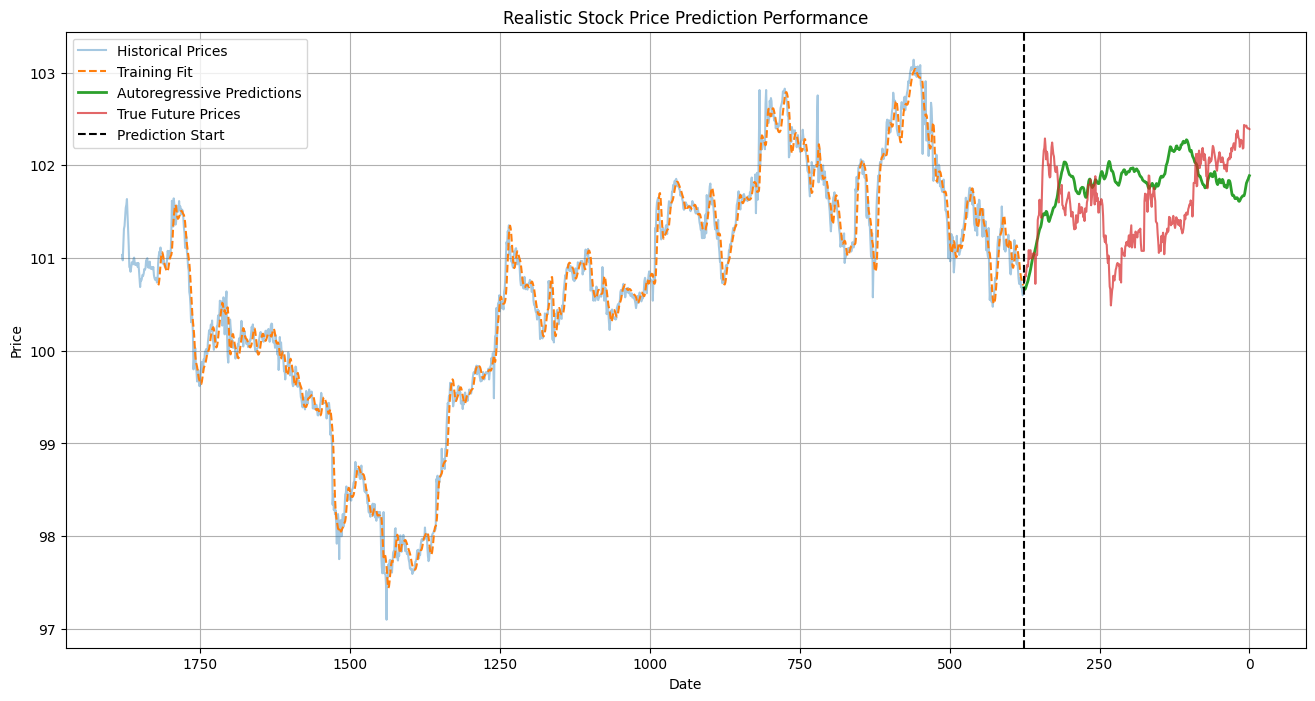

In [14]:
# Evaluate properly
model.eval()
pred_prices, true_prices = visualize_predictions(
    model, scaler, scaled_train, scaled_test, 
    SEQ_LENGTH, feature_columns
)

# Calculate metrics
# rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
# mae = mean_absolute_error(true_prices, pred_prices)
# direction_acc = np.mean(np.diff(true_prices) * np.diff(pred_prices) > 0)

# print(f"""
# Realistic Performance Report:
# - RMSE: {rmse:.2f}
# - MAE: {mae:.2f}
# - Direction Accuracy: {direction_acc*100:.1f}%
# """)